In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add src directory to the Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "src")))

from pricing.triple_win import TripleWinPricing, TrackingTripleWinPricing
from pricing.buyer import BuyerBlock
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [3]:
df_shapley = pd.read_csv("../tables/unified_shapley_matrix_10sellers.csv")

selected_columns = []

MODELS_NUM = 10

for i in range(10):
    selected_columns.append(f"seller_{i}")
SV = df_shapley[selected_columns].sample(MODELS_NUM).values.transpose()
SV = SV / SV.sum(axis=0, keepdims=True)

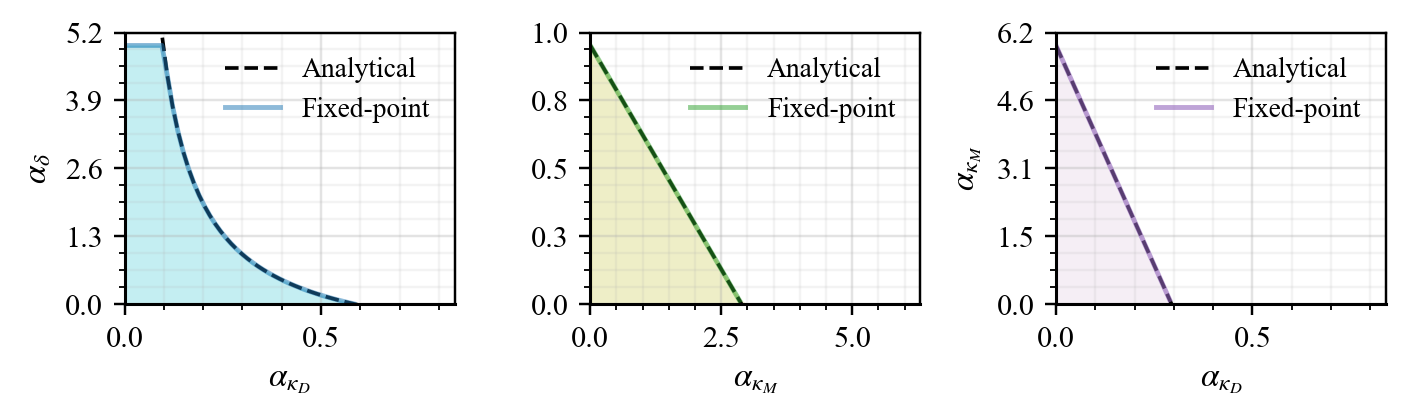

In [4]:
# === TripleWin feasibility: κ_D vs δ AND κ_M vs δ, analytical vs fixed-point ===
# Requirements: numpy, matplotlib, and your pricing.* modules on PYTHONPATH.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from copy import deepcopy

# ---- Plot typography (Times New Roman) ----
mpl.rcParams.update({
    "figure.dpi": 220,
    "savefig.dpi": 600,
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "mathtext.fontset": "stix",
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 9,
})

# ---- Imports from your project ----
from pricing.triple_win import TripleWinPricing
# from pricing.buyer import BuyerBlock   # only needed if you want to build synthetic buyers below

# -------------------------------------------------------------------
# Utilities: safe copies of buyers so we don't mutate the originals
# -------------------------------------------------------------------
def clone_buyers(buyers):
    """Deep-copy BuyerBlocks with numpy arrays copied to avoid side-effects."""
    bs = []
    for blk in buyers:
        new_blk = deepcopy(blk)
        # ensure arrays are independent
        new_blk.kappa_mb = np.array(blk.kappa_mb, dtype=float, copy=True)
        new_blk.R        = np.array(blk.R,        dtype=float, copy=True)
        new_blk.omega    = np.array(blk.omega,    dtype=float, copy=True)
        if hasattr(blk, "p_init") and blk.p_init is not None:
            new_blk.p_init = np.array(blk.p_init, dtype=float, copy=True)
        if hasattr(blk, "p0") and blk.p0 is not None:
            new_blk.p0 = np.array(blk.p0, dtype=float, copy=True)
        bs.append(new_blk)
    return bs

# -------------------------------------------------------------------
# Analytical frontiers
# -------------------------------------------------------------------
def _precompute_Ajk_and_cardG(buyers, SV):
    """Precompute A_{jk} and |G_j| used by analytical formulas."""
    SV = np.asarray(SV, dtype=float)
    I, J = SV.shape
    card_G = (SV > 0).sum(axis=0).astype(int)
    card_G[card_G == 0] = 1  # guard: if a column is all zeros

    rho = np.array([np.sum(blk.omega) for blk in buyers], dtype=float)  # (J,)
    A_list = []
    for j, blk in enumerate(buyers):
        kappa_mb = np.asarray(blk.kappa_mb, dtype=float)  # (K_j,)
        R = np.asarray(blk.R, dtype=float)                # (K_j,)
        omega = np.asarray(blk.omega, dtype=float)        # (K_j,)
        kappa_hat = float(np.dot(omega, kappa_mb))
        Ajk = (1.0 - rho[j]) * (R - kappa_mb) - kappa_hat  # (K_j,)
        A_list.append(Ajk)
    return A_list, card_G, rho

def analytical_delta_max_vs_kappaD(buyers, SV, kappaD_grid):
    """
    δ_max(κ_D) = min_{j,k} ( A_{jk} / (|G_j| κ_D) - 1 )
    where A_{jk} = (1-ρ_j)(R_{jk}-κ_{M_j→B_k}) - sum_m ω_{jm} κ_{M_j→B_m}.
    """
    A_list, card_G, _ = _precompute_Ajk_and_cardG(buyers, SV)
    kappaD_grid = np.asarray(kappaD_grid, dtype=float)
    out = np.empty_like(kappaD_grid, dtype=float)
    for t, kD in enumerate(kappaD_grid):
        vals = []
        denom_eps = max(kD, 1e-16)
        for j, Ajk in enumerate(A_list):
            denom = card_G[j] * denom_eps
            vals.extend(Ajk / denom - 1.0)
        out[t] = np.min(vals)
    return out

def analytical_delta_max_vs_kappaM(buyers, SV, kappaM_grid, kappaD_scalar):
    """
    When a UNIFORM buyer-side offset κ_M is added to all κ_{M_j→B_k},
    δ_max(κ_M) = min_{j,k} ( (A_{jk} - κ_M) / (|G_j| κ_D) - 1 ).
    """
    A_list, card_G, _ = _precompute_Ajk_and_cardG(buyers, SV)
    kappaM_grid = np.asarray(kappaM_grid, dtype=float)
    out = np.empty_like(kappaM_grid, dtype=float)
    denom_base = float(kappaD_scalar)
    denom_base = max(denom_base, 1e-16)
    for t, kM in enumerate(kappaM_grid):
        vals = []
        for j, Ajk in enumerate(A_list):
            denom = card_G[j] * denom_base
            vals.extend((Ajk - kM) / denom - 1.0)
        out[t] = np.min(vals)
    return out

# -------------------------------------------------------------------
# Fixed-point feasibility via TripleWin + bisection over δ
# -------------------------------------------------------------------
def _triplewin_feasible_for(buyers, SV, kappa_D_scalar, delta_scalar,
                            kappaM_uniform_add=0.0,
                            max_iter=2000, tol=1e-10, relax_eps=1e-9):
    """
    Run TripleWin at:
      - uniform κ_D across datasets,
      - uniform δ across models,
      - optional uniform κ_M added to ALL buyer-side κ_{M→B}.
    Returns (is_feasible, solver) where feasibility means all p_{M→B} ≤ R (with tiny slack).
    """
    I, J = SV.shape
    kappa_D_vec = np.full(I, float(kappa_D_scalar), dtype=float)
    delta_vec   = np.full(J, float(delta_scalar),   dtype=float)

    # Clone buyers and add uniform κ_M if requested
    buyers_local = clone_buyers(buyers)
    if abs(kappaM_uniform_add) > 0:
        for blk in buyers_local:
            blk.kappa_mb = blk.kappa_mb + float(kappaM_uniform_add)
            # keep p_init/p0 coherent if present
            if hasattr(blk, "p_init") and blk.p_init is not None:
                blk.p_init = blk.p_init + float(kappaM_uniform_add)
            if hasattr(blk, "p0") and blk.p0 is not None:
                blk.p0 = blk.p0 + float(kappaM_uniform_add)

    bar_p = np.ones((I, J), dtype=float)  # ignored by no-clipping base
    p0_D  = np.full((I, J), float(kappa_D_scalar), dtype=float)  # init p_{D→M}

    solver = TripleWinPricing(
        shapley_values=SV,
        delta=delta_vec,
        kappa_D=kappa_D_vec,
        buyers=buyers_local,
        C_var=kappa_D_vec,
        bar_p_DtoM=bar_p,
        p_DtoM_init=p0_D,
        tol=tol,
        max_iter=max_iter,
        verbose=False,
    )
    _ = solver.fit()

    # Feasibility: all model→buyer prices must be ≤ reserves (allow tiny slack)
    ok = True
    for j, blk in enumerate(buyers_local):
        if np.any(solver.p_MtoB[j] - blk.R > relax_eps):
            ok = False
            break
    return ok, solver

def frontier_delta_vs_kappaD_fixedpoint(buyers, SV, kappaD_grid,
                                        delta_hi_cap=5.0, grow_factor=1.8,
                                        tol_bisect=1e-4, max_iter=2000, tol_fp=1e-10):
    """
    For each κ_D, find the largest δ ≥ 0 such that TripleWin is feasible (buyers’ R respected).
    """
    kappaD_grid = np.asarray(kappaD_grid, dtype=float)
    delta_star = np.full_like(kappaD_grid, np.nan, dtype=float)

    for t, kD in enumerate(kappaD_grid):
        # If baseline δ=0 infeasible, mark and continue
        feas0, _ = _triplewin_feasible_for(buyers, SV, kD, 0.0, max_iter=max_iter, tol=tol_fp)
        if not feas0:
            delta_star[t] = -np.inf
            continue

        # Exponential search then bisection
        lo, hi = 0.0, 0.05
        ok, _ = _triplewin_feasible_for(buyers, SV, kD, hi, max_iter=max_iter, tol=tol_fp)
        while ok and hi < delta_hi_cap:
            lo = hi
            hi = min(delta_hi_cap, hi * grow_factor + 1e-12)
            ok, _ = _triplewin_feasible_for(buyers, SV, kD, hi, max_iter=max_iter, tol=tol_fp)
        if ok:
            delta_star[t] = hi
            continue

        for _ in range(60):
            mid = 0.5 * (lo + hi)
            ok_mid, _ = _triplewin_feasible_for(buyers, SV, kD, mid, max_iter=max_iter, tol=tol_fp)
            if ok_mid:
                lo = mid
            else:
                hi = mid
            if hi - lo <= tol_bisect * max(1.0, lo):
                break
        delta_star[t] = lo
    return delta_star

def frontier_delta_vs_kappaM_fixedpoint(buyers, SV, kappaM_grid, kappaD_scalar,
                                        delta_hi_cap=5.0, grow_factor=1.8,
                                        tol_bisect=1e-4, max_iter=2000, tol_fp=1e-10):
    """
    For each κ_M (uniform add to all κ_{M→B}), find the largest δ ≥ 0 feasible, with κ_D fixed.
    """
    kappaM_grid = np.asarray(kappaM_grid, dtype=float)
    delta_star = np.full_like(kappaM_grid, np.nan, dtype=float)

    for t, kM in enumerate(kappaM_grid):
        # Baseline δ=0
        feas0, _ = _triplewin_feasible_for(buyers, SV, kappaD_scalar, 0.0,
                                           kappaM_uniform_add=kM, max_iter=max_iter, tol=tol_fp)
        if not feas0:
            delta_star[t] = -np.inf
            continue

        # Exponential search then bisection
        lo, hi = 0.0, 0.05
        ok, _ = _triplewin_feasible_for(buyers, SV, kappaD_scalar, hi,
                                        kappaM_uniform_add=kM, max_iter=max_iter, tol=tol_fp)
        while ok and hi < delta_hi_cap:
            lo = hi
            hi = min(delta_hi_cap, hi * grow_factor + 1e-12)
            ok, _ = _triplewin_feasible_for(buyers, SV, kappaD_scalar, hi,
                                            kappaM_uniform_add=kM, max_iter=max_iter, tol=tol_fp)
        if ok:
            delta_star[t] = hi
            continue

        for _ in range(60):
            mid = 0.5 * (lo + hi)
            ok_mid, _ = _triplewin_feasible_for(buyers, SV, kappaD_scalar, mid,
                                                kappaM_uniform_add=kM, max_iter=max_iter, tol=tol_fp)
            if ok_mid:
                lo = mid
            else:
                hi = mid
            if hi - lo <= tol_bisect * max(1.0, lo):
                break
        delta_star[t] = lo
    return delta_star

# -------------------------------------------------------------------
# Plotting: 1 row × 2 columns, shaded feasible regions, Times New Roman
# -------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt

def plot_dual_frontiers(
    kappaD_grid, deltaD_anal, deltaD_num,
    kappaM_grid, deltaM_anal, deltaM_num,
    title_left=r"Feasible Region: $(\alpha_{\kappa_D},\,\delta)$ (with $\alpha_{\kappa_M}$ fixed)",
    title_right=r"Feasible Region: $(\alpha_{\kappa_M},\,\delta)$ (with $\alpha_{\kappa_D}$ fixed)"
):
    # Prepare shaded areas (under numerical frontiers)
    shadeD = np.maximum(0.0, np.asarray(deltaD_num, dtype=float))
    shadeM = np.maximum(0.0, np.asarray(deltaM_num, dtype=float))

    # --- FIGURE SIZE: half of previous (≈ 4.3 × 2.0 inches) ---
    width_in = 4.3
    height_in = width_in / 2.2
    fig, axes = plt.subplots(1, 2, figsize=(width_in, height_in), sharey=False)

    # ---------------------
    # Left panel: κ_D vs δ
    # ---------------------
    ax = axes[0]
    # Analytical: black dashed
    ax.plot(kappaD_grid, deltaD_anal, linewidth=1.2, linestyle="--", color="black", label="Analytical")

    # Fixed-point: solid (distinct color)
    fp_color_D = "tab:blue"
    shade_color_D = "tab:cyan"
    ax.plot(kappaD_grid, deltaD_num, linewidth=1.6, linestyle="-", color=fp_color_D, label="Fixed-point", alpha=0.5)
    ax.fill_between(kappaD_grid, 0.0, shadeD, alpha=0.25, color=shade_color_D)

    ax.set_xlabel(r"$\alpha_{\kappa_D}$")
    ax.set_ylabel(r"$\delta$")
    # ax.set_title(title_left)

    # Y-limits & ticks (panel-specific)
    ymaxD = float(shadeD.max() * 1.05) if shadeD.size and np.isfinite(shadeD).any() else 1.0
    ax.set_ylim(0.0, ymaxD)
    yticksD = np.linspace(0.0, ymaxD, 5)
    ax.set_yticks(yticksD)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))


    ax.minorticks_on()
    ax.grid(True, which="major", alpha=0.35)
    ax.grid(True, which="minor", alpha=0.15)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(True)
    for spine in ("left", "bottom"):
        ax.spines[spine].set_linewidth(1.0)

    ax.legend(frameon=False, loc="upper right")

    # ----------------------
    # Right panel: κ_M vs δ
    # ----------------------
    ax = axes[1]
    # Analytical: black dashed
    ax.plot(kappaM_grid, deltaM_anal, linewidth=1.2, linestyle="--", color="black", label="Analytical")

    # Fixed-point: solid (different color from left)
    fp_color_M = "tab:green"
    shade_color_M = "tab:olive"
    ax.plot(kappaM_grid, deltaM_num, linewidth=1.6, linestyle="-", color=fp_color_M, label="Fixed-point", alpha=0.5)
    ax.fill_between(kappaM_grid, 0.0, shadeM, alpha=0.25, color=shade_color_M)

    ax.set_xlabel(r"$\alpha_{\kappa_M}$")

    # Y-limits & ticks (panel-specific)
    ymaxM = float(shadeM.max() * 1.05) if shadeM.size and np.isfinite(shadeM).any() else 1.0
    ax.set_ylim(0.0, ymaxM)
    yticksM = np.linspace(0.0, ymaxM, 5)
    ax.set_yticks(yticksM)
    ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))

    ax.minorticks_on()
    ax.grid(True, which="major", alpha=0.35)
    ax.grid(True, which="minor", alpha=0.15)
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(True)
    for spine in ("left", "bottom"):
        ax.spines[spine].set_linewidth(1.0)

    ax.legend(frameon=False, loc="upper right")

    # Ensure x starts at 0 in both panels
    for ax in axes:
        ax.set_xlim(left=0.0)

    fig.tight_layout()

    fig.savefig("../plots/feasible_region.pdf", format="pdf", bbox_inches="tight")
    plt.show()

# =========================
# Additions to your script
# =========================
from matplotlib.ticker import FormatStrFormatter

# --- Analytical κ_M^max vs κ_D at fixed δ ---
def analytical_kMmax_vs_kD(buyers, SV, kappaD_grid, delta_fixed):
    """
    κ_M^max(κ_D; δ) = min_{j,k} [ A_{jk} - (1+δ) |G_j| κ_D ].
    Everything under the curve is feasible for that fixed δ.
    """
    A_list, card_G, _ = _precompute_Ajk_and_cardG(buyers, SV)
    kappaD_grid = np.asarray(kappaD_grid, dtype=float)
    out = np.empty_like(kappaD_grid, dtype=float)
    slope = (1.0 + float(delta_fixed)) * card_G  # shape (J,)
    for t, kD in enumerate(kappaD_grid):
        vals = []
        for j, Ajk in enumerate(A_list):
            vals.extend(Ajk - slope[j] * kD)  # one line per (j,k)
        out[t] = np.min(vals)
    return out

# --- Fixed-point κ_M^max vs κ_D at fixed δ (bisection in κ_M) ---
def frontier_kMmax_vs_kD_fixedpoint(buyers, SV, kappaD_grid, delta_fixed,
                                    kappaM_hi_cap=15.0, grow_factor=1.8,
                                    tol_bisect=1e-4, max_iter=2000, tol_fp=1e-10):
    kappaD_grid = np.asarray(kappaD_grid, dtype=float)
    kM_star = np.full_like(kappaD_grid, np.nan, dtype=float)
    for t, kD in enumerate(kappaD_grid):
        feas0, _ = _triplewin_feasible_for(buyers, SV, kD, delta_fixed,
                                           kappaM_uniform_add=0.0,
                                           max_iter=max_iter, tol=tol_fp)
        if not feas0:
            kM_star[t] = -np.inf
            continue
        lo, hi = 0.0, 0.5
        ok, _ = _triplewin_feasible_for(buyers, SV, kD, delta_fixed,
                                        kappaM_uniform_add=hi,
                                        max_iter=max_iter, tol=tol_fp)
        while ok and hi < kappaM_hi_cap:
            lo = hi
            hi = min(kappaM_hi_cap, hi * grow_factor + 1e-12)
            ok, _ = _triplewin_feasible_for(buyers, SV, kD, delta_fixed,
                                            kappaM_uniform_add=hi,
                                            max_iter=max_iter, tol=tol_fp)
        if ok:
            kM_star[t] = hi
            continue
        for _ in range(60):
            mid = 0.5 * (lo + hi)
            ok_mid, _ = _triplewin_feasible_for(buyers, SV, kD, delta_fixed,
                                                kappaM_uniform_add=mid,
                                                max_iter=max_iter, tol=tol_fp)
            if ok_mid: lo = mid
            else:      hi = mid
            if hi - lo <= tol_bisect * max(1.0, lo): break
        kM_star[t] = lo
    return kM_star

# --- NEW: 1×3 plotting with your style ---
def plot_triple_frontiers(
    # left two panels (same inputs as your plot_dual_frontiers):
    kappaD_grid, deltaD_anal, deltaD_num,
    kappaM_grid, deltaM_anal, deltaM_num,
    # third panel: κ_M^max vs κ_D at fixed δ
    kappaD_grid_C, kMmax_anal, kMmax_num, delta_fixed,
    savepath="../plots/feasible_region_1x3.pdf"
):
    shadeD = np.maximum(0.0, np.asarray(deltaD_num, dtype=float))
    shadeM = np.maximum(0.0, np.asarray(deltaM_num, dtype=float))
    shadeC = np.maximum(0.0, np.asarray(kMmax_num, dtype=float))

    # Same compact style (half-size vibe), scaled for 3 panels
    width_in = 6.5
    height_in = 2
    fig, axes = plt.subplots(1, 3, figsize=(width_in, height_in), sharey=False)

    # -------- Panel A: δ vs κ_D --------
    ax = axes[0]
    ax.plot(kappaD_grid, deltaD_anal, linestyle="--", color="black", linewidth=1.2, label="Analytical")
    ax.plot(kappaD_grid, deltaD_num,  linestyle="-",  color="tab:blue", linewidth=1.6, alpha=0.5, label="Fixed-point")
    ax.fill_between(kappaD_grid, 0.0, shadeD, alpha=0.25, color="tab:cyan")
    ax.set_xlabel(r"$\alpha_{\kappa_D}$")
    ax.set_ylabel(r"$\alpha_{\delta}$")
    ymax = float(shadeD.max() * 1.05) if shadeD.size and np.isfinite(shadeD).any() else 1.0
    ax.set_ylim(0.0, ymax)
    ax.set_yticks(np.linspace(0.0, ymax, 5)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.minorticks_on(); ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15)
    for s in ("top","right"): ax.spines[s].set_visible(True)
    for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)
    ax.legend(frameon=False, loc="upper right")

    # -------- Panel B: δ vs κ_M --------
    ax = axes[1]
    ax.plot(kappaM_grid, deltaM_anal, linestyle="--", color="black", linewidth=1.2, label="Analytical")
    ax.plot(kappaM_grid, deltaM_num,  linestyle="-",  color="tab:green", linewidth=1.6, alpha=0.5, label="Fixed-point")
    ax.fill_between(kappaM_grid, 0.0, shadeM, alpha=0.25, color="tab:olive")
    ax.set_xlabel(r"$\alpha_{\kappa_M}$")
    ymax = float(shadeM.max() * 1.05) if shadeM.size and np.isfinite(shadeM).any() else 1.0
    ax.set_ylim(0.0, ymax)
    ax.set_yticks(np.linspace(0.0, ymax, 5)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.minorticks_on(); ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15)
    for s in ("top","right"): ax.spines[s].set_visible(True)
    for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)
    ax.legend(frameon=False, loc="upper right")

    # -------- Panel C: κ_M^max vs κ_D at fixed δ --------
    ax = axes[2]
    ax.plot(kappaD_grid_C, kMmax_anal, linestyle="--", color="black", linewidth=1.2, label="Analytical")
    ax.plot(kappaD_grid_C, kMmax_num,  linestyle="-",  color="tab:purple", linewidth=1.6, alpha=0.6, label="Fixed-point")
    ax.fill_between(kappaD_grid_C, 0.0, shadeC, alpha=0.25, color="thistle")
    ax.set_xlabel(r"$\alpha_{\kappa_D}$")
    ax.set_ylabel(r"$\alpha_{\kappa_M}$")
    ymax = float(np.nanmax(shadeC) * 1.05) if shadeC.size and np.isfinite(shadeC).any() else 1.0
    ax.set_ylim(0.0, ymax)
    ax.set_yticks(np.linspace(0.0, ymax, 5)); ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
    ax.minorticks_on(); ax.grid(True, which="major", alpha=0.35); ax.grid(True, which="minor", alpha=0.15)
    for s in ("top","right"): ax.spines[s].set_visible(True)
    for s in ("left","bottom"): ax.spines[s].set_linewidth(1.0)
    ax.legend(frameon=False, loc="upper right")

    for ax in axes: ax.set_xlim(left=0.0)
    fig.tight_layout()
    fig.savefig(savepath, format="pdf", bbox_inches="tight")
    plt.show()


# -------------------------------------------------------------------
# Demo / Usage
# -------------------------------------------------------------------

# --- Replace this synthetic block with your real `buyers` and `SV` if you have them ---
rng = np.random.default_rng(70)
I, J = SV.shape

class BuyerBlock:
    def __init__(self, kappa_mb, R, omega):
        self.kappa_mb = np.asarray(kappa_mb, dtype=float)
        self.R = np.asarray(R, dtype=float)
        self.omega = np.asarray(omega, dtype=float)
        self.p_init = None
        self.p0 = self.kappa_mb

buyers = []
RHO = 0.6
for j in range(J):
    K_j = rng.integers(2, 6)  # 2–5 buyers per model
    kappa_mb = rng.uniform(1.0, 5.0, size=K_j)
    R = rng.uniform(25.0, 100.0, size=K_j)
    omega = np.full(K_j, RHO / K_j)
    buyers.append(BuyerBlock(kappa_mb, R, omega))

# --- Grids and fixed κ_D baseline for κ_M plot ---
kappaD_grid = np.linspace(0.0001, 0.80, 60)
kappaM_grid = np.linspace(0.0, 6.0, 60)     # buyer-side offset sweep
kappaD_baseline = 0.30                        # fix κ_D for the κ_M–δ plot

# --- Analytical frontiers ---
deltaD_anal = analytical_delta_max_vs_kappaD(buyers, SV, kappaD_grid)
deltaM_anal = analytical_delta_max_vs_kappaM(buyers, SV, kappaM_grid, kappaD_scalar=kappaD_baseline)

# --- Fixed-point (TripleWin) frontiers ---
deltaD_num = frontier_delta_vs_kappaD_fixedpoint(
    buyers, SV, kappaD_grid,
    delta_hi_cap=5.0, grow_factor=1.8, tol_bisect=1e-4, max_iter=100, tol_fp=1e-10
)
deltaM_num = frontier_delta_vs_kappaM_fixedpoint(
    buyers, SV, kappaM_grid, kappaD_scalar=kappaD_baseline,
    delta_hi_cap=5.0, grow_factor=1.8, tol_bisect=1e-4, max_iter=100, tol_fp=1e-10
)

# --- Third panel inputs ---
delta_fixed = 1.0
kappaD_grid_C = np.linspace(0.0001, 0.80, 120)

kMmax_anal = analytical_kMmax_vs_kD(buyers, SV, kappaD_grid_C, delta_fixed)
kMmax_num  = frontier_kMmax_vs_kD_fixedpoint(
    buyers, SV, kappaD_grid_C, delta_fixed,
    kappaM_hi_cap=10.0, grow_factor=1.8, tol_bisect=1e-4, max_iter=100, tol_fp=1e-10
)

# --- Plot all three panels with your style ---
plot_triple_frontiers(
    kappaD_grid, deltaD_anal, deltaD_num,
    kappaM_grid, deltaM_anal, deltaM_num,
    kappaD_grid_C, kMmax_anal, kMmax_num, delta_fixed,
    savepath="../plots/feasible_region.pdf"
)
